# Gravitational Orbits 
Here we use python to numerically solve the two body problem in cartesian coridiantes

We start by looking the the lagrangian of our system. $T=1/2 m_1(\dot{x_1}^2+\dot{y_1}^2)+1/2m_2(\dot{x_2}^2+\dot{y_2}^2)$ and $U=\frac{Gm_1m_2}{r}$. We then contruct the Lagrangian $\mathcal{L}= T-U$ and use Lagrange's equation to construct the following equations of motion.


$\ddot{x_1}=\eta m_2 (x_2-x_1)$


$\ddot{x_2}=\eta m_1 (x_1-x_2)$


$\ddot{y_1}=\eta m_2 (y_2-y_1)$


$\ddot{y_2}=\eta m_1 (y_1-y_2)$


Where $\eta$ is given by


$\eta= \frac{G}{[(x_1-x_2)^2+(y_1-y_2)^2]^{3/2}}$

To solve this in python we create a 8 compnent vector

$\begin{align}
  \mathbf{y} = \left(\begin{array}{c} x_1(t) \\ \dot x_1(t) \\ x_2(t) \\ \dot{x_2}(t) \\ y_1(t) \\ \dot{y_1}(t) \\ y_2(t) \\ \dot{y_2}(t)  \end{array} \right) 
  \qquad
\end{align}$
From this we calculate $dy/dt$ and use solve_ivp to numerically solve this differential. Also included below is the leap frog method which allows for the conservation of energy.


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

In [3]:
class Orbit:
    """
    Potentials and associated differential equations for central force motion
    with the potential U(r) = k r^(-1) representing gravitiational potential.
    """
    
    def __init__(self, m1, m2, k):
        self.m1= m1
        self.m2=m2
        self.k = k
        
    
    
    def dy_dt(self, t, y):
        """
        This function returns the right-hand side of the diffeq: 
      
        
        Parameters
        ----------
        t : float
            time 
        y : float
            8-component vector with y[0] = x0(t), y[1] = dx0/dt, y[2] = x1(t)
            
        """
        hold= self.k*(((y[0]-y[2])**2+(y[4]-y[6])**2)**(-3/2)) 
        return [ y[1],\
                hold*self.m2*(y[2]-y[0]),\
                y[3],\
                hold*self.m1*(y[0]-y[2]),\
                y[5],\
                hold*self.m2*(y[6]-y[4]),\
                y[7],\
                hold*self.m1*(y[4]-y[6])
                ]
    
    
    def solve_ode(self, t_pts, x0, x_dot0, x1,x_dot1,y0,y_dot0,y1,y_dot1, 
                  abserr=1.0e-8, relerr=1.0e-8):
        """
        Solve the ODE given initial conditions.
        For now use odeint, but we have the option to switch.
        Specify smaller abserr and relerr to get more precision.
        """
        y = [x0, x_dot0, x1, x_dot0, y0, y_dot0, y1, y_dot1]  
        solution = solve_ivp(self.dy_dt, (t_pts[0], t_pts[-1]), 
                             y, t_eval=t_pts, 
                             atol=abserr, rtol=relerr)
        x0, x_dot0, x1, x_dot0, y0, y_dot0, y1, y_dot1 = solution.y
        return x0, x_dot0, x1, x_dot0, y0, y_dot0, y1, y_dot1
    
    def solve_ode_Leapfrog(self, t_pts, x0, x_dot0, x1, x_dot1, y0, y_dot0, y1, y_dot1):
        """
        Solve the ODE given initial conditions with the Leapfrog method.
        """
        delta_t = t_pts[1] - t_pts[0]
        
        # initialize the arrays for r, rdot, r_dot_half, phi with zeros
        num_t_pts = len(t_pts)
        x0 = np.zeros(num_t_pts)
        x_dot0 = np.zeros(num_t_pts)
        x_dot0_half = np.zeros(num_t_pts)
        y0 = np.zeros(num_t_pts)
        y_dot0 = np.zeros(num_t_pts)
        y_dot_half = np.zeros(num_t_pts)
        x1 = np.zeros(num_t_pts)
        x_dot1 = np.zeros(num_t_pts)
        x_dot1_half = np.zeros(num_t_pts)
        y1 = np.zeros(num_t_pts)
        y_dot1 = np.zeros(num_t_pts)
        y_dot1_half = np.zeros(num_t_pts)
        phi = np.zeros(num_t_pts)
        
        # initial conditions
        x0[0] = x0
        x_dot[0] = x_dot0
        y0[0] = x0
        y_dot[0] = x_dot0
        x1[0] = x1
        x1_dot[0] = x_dot1
        y1[0] = y1
        y1_dot[0] = y_dot1
        phi[0] = phi_0
        
        # step through the differential equation
        for i in np.arange(num_t_pts - 1):
            t = t_pts[i]
            y = [x0[i], x_dot0[i], x1[i], x_dot1[i], y0[i], y_dot0[i], y1[i], y_dot1[i]]
            x0_dot_half[i] = x_dot0[i] + self.dy_dt(t, y)[1] * delta_t/2.
            x0[i+1] = x0[i] + x0_dot_half[i] * delta_t
            
            y = [x0[i+1], x_dot0[i], x1[i], x_dot1[i], y0[i], y_dot0[i], y1[i], y_dot1[i]]
            x_dot0[i+1] = x0_dot_half[i] + self.dy_dt(t, y)[1] * delta_t/2.
            
            x1_dot_half[i] = x_dot1[i] + self.dy_dt(t, y)[3] * delta_t/2.
            x1[i+1] = x1[i] + x1_dot_half[i] * delta_t
            
            y = [x0[i], x_dot0[i], x1[i+1], x_dot1[i], y0[i], y_dot0[i], y1[i], y_dot1[i]]
            x_dot1[i+1] = x1_dot_half[i] + self.dy_dt(t, y)[3] * delta_t/2.
            
            y0_dot_half[i] = y_dot0[i] + self.dy_dt(t, y)[5] * delta_t/2.
            y0[i+1] = y0[i] + y0_dot_half[i] * delta_t
            
            y = [x0[i], x_dot0[i], x1[i], x_dot1[i], y0[i+1], y_dot0[i], y1[i], y_dot1[i]]
            y_dot0[i+1] = y0_dot_half[i] + self.dy_dt(t, y)[5] * delta_t/2.
            
            y1_dot_half[i] = y_dot1[i] + self.dy_dt(t, y)[7] * delta_t/2.
            y1[i+1] = y1[i] + y1_dot_half[i] * delta_t
            
            y = [x0[i], x_dot0[i], x1[i], x_dot1[i], y0[i], y_dot0[i], y1[i+1], y_dot1[i]]
            y_dot1[i+1] = y1_dot_half[i] + self.dy_dt(t, y)[7] * delta_t/2.
            
            
        return x0, x_dot0, x1, x_dot0, y0, y_dot0, y1, y_dot1  
    
    def energy(self, t_pts, r, r_dot):
        """Evaluate the energy as a function of time"""
        return (self.mu/2.) * r_dot**2 + self.Ueff(r)

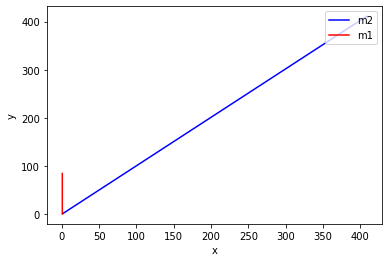

In [10]:
test = Orbit(m1 = 1.0, m2 = 10000., k=-1)
m1 = 1.0
m2 = 100.0

t_pts = np.arange(0, 5, 0.1)

x0, x_dot0 = 1., .5
y0, y_dot0 = 1., .5

x1, x_dot1 = 0, 0
y1, y_dot1 = 0 , 0


r = [x0, x_dot0, x1, x_dot1, y0, y_dot0, y1, y_dot1]

q = test.solve_ode(t_pts, x0, x_dot0,x1,x_dot1,y0,y_dot0,y1,y_dot1)

fig = plt.figure()
ax = fig.add_subplot(1,1,1)



ax.plot(q[0],q[4], color='blue', label='m2')
ax.plot(q[1],q[5], color='red', label='m1')



ax.set_xlabel('x')
ax.set_ylabel('y')
ax.legend(loc='upper right')


